# Logistic Regression with Pytorch



Pytorch is a powerful library to address Machine Learning problems. It is provided with automatic differentiation tools. 

In [1]:
import pandas as pd # pd is simply an alias 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #High quality figures

## Pre-processing a real dataset

We will be using the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), which contains 10 features related to breast tumors that have been diagnosed as benign or malignant. 

In [2]:
def load_spam():
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',header=None)
    data.columns=['ID', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class']
    return data

In [3]:
''' Data is stored in a Dataframe, a particular data type implemented in Pandas'''

data = load_spam()


Lets visualize the first 10 entries of the database with the `.head()` method

In [4]:
data.head(10)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


We will do some preprocessing steps:

- Remove the 'ID' column. 

- Analyze missing data 

- The tumor class is equal to 2 for bening tumors and to 4 for malignat tumors. We will replace this by 0 and 1 respectively

- Create a train set and a test set

- We will normalize all input variables so they all have zero mean and unit variance

### Remove ID colum

We can use the `.drop()` method. We use the input `inplace=True` to override the existing Dataframe.

In [5]:
data.drop('ID', axis=1, inplace=True)

In [6]:
# Lets check the result

data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
5,8,10,10,8,7,10,9,7,1,4
6,1,1,1,1,2,10,3,1,1,2
7,2,1,2,1,2,1,3,1,1,2
8,2,1,1,1,2,1,1,1,5,2
9,4,2,1,1,2,1,2,1,1,2


### Missing data

Using `apply()` across all of the columns in our DataFrame leads us to figure out which values are missing. But first we  change the `?` missing codification by `NaN`.

In [7]:
data.replace('?', np.nan, inplace=True)

In [8]:
empty = data.apply(lambda col: pd.isnull(col))

In [9]:
empty.sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

Observe that only one of the columns has 16 missing entries. For simplicity, let's remove this column. Be aware that in general we will impute missing data with some representative value. 

In [10]:
data.drop('Bare Nuclei', axis=1, inplace=True)

In [11]:
empty = data.apply(lambda col: pd.isnull(col))
empty.sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

### Create a binary class label

To do so, we will create a simple function to convert the label and store the result in a new colum of the dataframe

In [12]:
def convert_to_binary(l):
    return (l-2.0)/2 #because the values are 4 or 2, they now can become either 0 or 1.

In [13]:
# We create the new column

data['Binary Class'] = data[['Class']].apply(lambda l: convert_to_binary(l))

data.drop('Class', axis=1, inplace=True)

### Create a train and test sets

We will simply split the dataset at random. 80% of the data will go to the training set, the rest to the test set.

In [15]:
frac_train = 0.8

data_train = int(data.shape[0]*frac_train) # Training points

np.random.seed(seed=10) # To fix the random seed. So we all get the same partition

mask = np.random.permutation(data.shape[0]) # Random order of data indexes

train_data = data.iloc[list(mask[:data_train])].copy()

test_data = data.iloc[list(mask[data_train:])].copy()

train_data


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Binary Class
285,8,10,10,10,8,10,7,3,1.0
607,1,1,1,1,2,1,1,1,0.0
587,5,1,1,1,2,2,2,1,0.0
458,5,1,2,1,2,1,1,1,0.0
431,5,1,1,3,4,3,2,1,0.0
...,...,...,...,...,...,...,...,...,...
263,10,4,4,10,6,5,5,1,1.0
103,8,2,3,1,6,7,1,1,1.0
347,1,1,1,1,1,1,3,1,0.0
551,1,1,1,1,2,3,1,1,0.0


### Normalize input variables 

To improve both the numerical robustness of our estimators and **enhance interpretability**, we will apply a linear normalization preprocessing stage to use as input to the linear regression features with (sample) mean 0 and (sample) variance equal to 1. 
The test set shall be normalized **using the train set statistics (mean and variance)**

In [17]:
means = train_data.mean()
stds = train_data.std()

In [18]:
for idx, column_name in enumerate(train_data.columns[:-1]):
    print(column_name)
    train_data[column_name] = (train_data[column_name]-means[idx])/(stds[idx])
    test_data[column_name] = (test_data[column_name]-means[idx])/(stds[idx])

Clump Thickness
Uniformity of Cell Size
Uniformity of Cell Shape
Marginal Adhesion
Single Epithelial Cell Size
Bland Chromatin
Normal Nucleoli
Mitoses


Lets take a look to the resulting dataframe

In [19]:
train_data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Binary Class
285,1.300525,2.285664,2.276496,2.455409,2.286331,2.658239,1.330666,0.867001,1.0
607,-1.212539,-0.700359,-0.747811,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
587,0.223498,-0.700359,-0.747811,-0.642951,-0.552749,-0.603117,-0.284977,-0.338605,0.0
458,0.223498,-0.700359,-0.411777,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
431,0.223498,-0.700359,-0.747811,0.045573,0.393611,-0.195448,-0.284977,-0.338605,0.0
52,2.018543,-0.036799,0.932359,-0.298689,-0.079569,0.212222,2.300052,0.264198,1.0
560,0.223498,-0.700359,-0.747811,-0.642951,-0.552749,-0.195448,-0.608106,-0.338605,0.0
445,-0.853530,-0.700359,-0.747811,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
292,1.300525,1.622103,1.604428,-0.642951,-0.552749,1.027561,2.300052,-0.338605,1.0
579,-1.212539,-0.700359,-0.747811,-0.642951,-0.552749,-0.195448,-0.608106,-0.338605,0.0


In [20]:

x = np.array(train_data).astype(np.float32)
# Last Column is the class
y = x[:, -1]  
x = x[:, :-1]

print('x', x)
print('y', y)

x [[ 1.300525    2.2856638   2.2764957  ...  2.6582384   1.3306657
   0.8670005 ]
 [-1.2125387  -0.7003592  -0.7478111  ... -1.010787   -0.60810614
  -0.3386047 ]
 [ 0.22349761 -0.7003592  -0.7478111  ... -0.60311747 -0.2849775
  -0.3386047 ]
 ...
 [-1.2125387  -0.7003592  -0.7478111  ... -1.010787    0.03815114
  -0.3386047 ]
 [-1.2125387  -0.7003592  -0.7478111  ... -0.195448   -0.60810614
  -0.3386047 ]
 [ 0.22349761 -0.7003592  -0.7478111  ... -0.60311747 -0.60810614
  -0.3386047 ]]
y [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1

When can define a logistic regressor by instantiating the class `LR_compact`, we can access the weights and the bias as `self.output.weight` and `self.output.bias`. We will define the data to be used, $x$ as an array of the train_data. It will be used for training the model, while the $y$ array will be used for testing.

In [21]:

from torch import nn

class LR_compact(nn.Module):
    def __init__(self,dimx):
        super().__init__()
        
        self.output = nn.Linear(dimx, 1)
    
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [22]:
''' This class inherits from the LR_compact class. So it has the same atributes
and methods, and some others that we will add. 
'''

import torch

class LR_extended(LR_compact):
    
    def __init__(self, dimx, sgd_iterations=1000, lr=0.001, print_every=500):
        
        super().__init__(dimx)  #To initialize LR_compact!
        
        self.lr = lr #Learning Rate
        
        self.optim = torch.optim.SGD(self.parameters(), self.lr)
        
        self.sgd_iterations = sgd_iterations #SGD steps
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.print_every = print_every
        
    def train(self,x,y):
        
        # SGD Loop
        
        for iter in range(int(self.sgd_iterations)):
        
            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.forward(x)

            loss = self.criterion(out, y.view(x.shape[0], 1)) #so the shapes are correct.

            self.loss_during_training.append(loss.item())

            loss.backward()

            self.optim.step()
        
            if(iter % self.print_every == 0): # Every iteration 
                
                print("Training loss after %d iterations: %f" 
                      %(iter,self.loss_during_training[-1]))
        

In [23]:
my_LR = LR_extended(x.shape[1], sgd_iterations=3000, lr=0.001)

my_LR.train(torch.tensor(x), torch.tensor(y))

Training loss after 0 iterations: 0.810289
Training loss after 500 iterations: 0.483420
Training loss after 1000 iterations: 0.354025
Training loss after 1500 iterations: 0.287413
Training loss after 2000 iterations: 0.247579
Training loss after 2500 iterations: 0.221384


Training loss after 0 iterations: 0.387780
Training loss after 500 iterations: 0.294271
Training loss after 1000 iterations: 0.245697
Training loss after 1500 iterations: 0.216062
Training loss after 2000 iterations: 0.196153
Training loss after 2500 iterations: 0.181896
Training loss after 3000 iterations: 0.171207
Training loss after 3500 iterations: 0.162913
Training loss after 4000 iterations: 0.156303
Training loss after 4500 iterations: 0.150918
Training loss after 5000 iterations: 0.146454
Training loss after 5500 iterations: 0.142697
Training loss after 6000 iterations: 0.139495
Training loss after 6500 iterations: 0.136735
Training loss after 7000 iterations: 0.134334
Training loss after 7500 iterations: 0.132227
Training loss after 8000 iterations: 0.130364
Training loss after 8500 iterations: 0.128706
Training loss after 9000 iterations: 0.127221
Training loss after 9500 iterations: 0.125884
Training loss after 10000 iterations: 0.124673
Training loss after 10500 iterations:

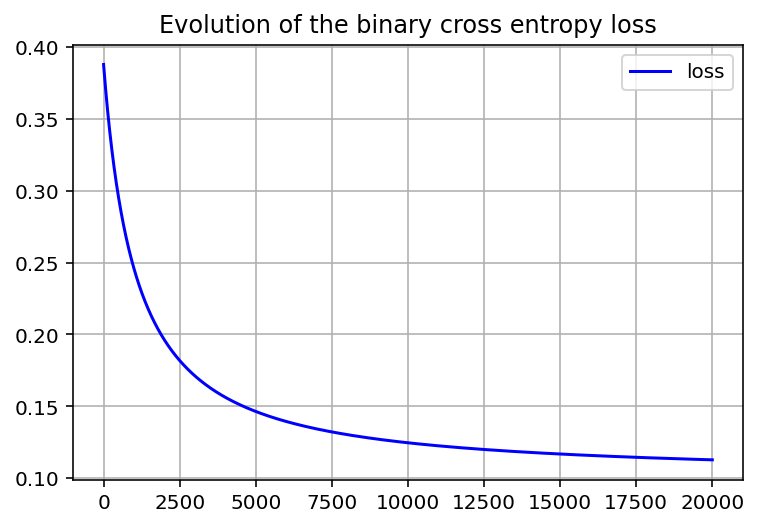

In [25]:
# Train from scratch the logistic regressor for 20.000 iterations
my_LR = LR_extended(x.shape[1], sgd_iterations=20000, lr=0.001)
my_LR.train(torch.tensor(x), torch.tensor(y))


plt.plot(my_LR.loss_during_training, '-b', label='loss')
plt.grid()
plt.title('Evolution of the binary cross entropy loss')
plt.legend()

We can see that the *loss* decreases as the number of iterations increases.

#### Evaluating the model in the test set

Now that we have trained our logistic regressor, it is time to compare its performance in both the training and the test sets.


In [27]:
# Logistic regressor output for both the training data and the test data.

my_LR = LR_extended(x.shape[1], sgd_iterations=3000, lr=0.001)

out_train = my_LR.forward(torch.tensor(x))

my_LR.train(torch.tensor(x), torch.tensor(y))

Training loss after 0 iterations: 0.845874
Training loss after 500 iterations: 0.480725
Training loss after 1000 iterations: 0.346469
Training loss after 1500 iterations: 0.280151
Training loss after 2000 iterations: 0.241089
Training loss after 2500 iterations: 0.215548


## Training a Logistic Regressor with mini-batch stochastic gradient descent

Finally, we are going to implement an scalable version of the gradient descent training implemented above. At every iteration, instead of evaluating the gradient using all data points, a small minibatch of data will be used.

To make sure that all training data points are evenly used to evaluate the gradient, we will use a short iterating function. Instead of predefining a certain number of SGD iterations, we define a certain number of **epochs**. After every epoch **all datapoints** have been used in the optimizer once. 



In [34]:
''' This class inherits from the LR_compact class. So it has the same atributes
and methods, and some others that we will add. 
'''

import torch

class LR_stochastic(LR_compact):
    
    def __init__(self, dimx, num_train_data,
                 epochs=100, lr=0.001, batch_size=50, print_every=20):
        
        super().__init__(dimx)  #To initialize LR2!
        
        self.lr = lr #Learning Rate
        
        self.optim = torch.optim.SGD(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.print_every = print_every  # Print loss every 
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.num_train = num_train_data
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        

        
    def train(self, x, y):
        
        # SGD Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                # Indexes of the datapoints that enter the batch
            
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                out = self.forward(x[idx_batch,:]) 

                loss = self.criterion(out, y[idx_batch].view(x[idx_batch,:].shape[0], 1))

                running_loss += loss.item()

                loss.backward()
                
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)

            if(e % self.print_every == 0): 
                print("Training loss after %d epochs: %f" %(e,self.loss_during_training[-1]))



    def evaluate(self, out_value, true_value):
      return np.sum((out_value.detach().numpy()>=0.5) == true_value.reshape([-1, 1]))/true_value.shape[0]


In [35]:

my_LR_stochastic = LR_stochastic(x.shape[1], num_train_data = x.shape[0], lr=0.001)
my_LR_stochastic.train(torch.tensor(x), torch.tensor(y))

#my_LR_stochastic.loss_during_training 

Training loss after 0 epochs: 0.735732
Training loss after 20 epochs: 0.567716
Training loss after 40 epochs: 0.462173
Training loss after 60 epochs: 0.395182
Training loss after 80 epochs: 0.345316


Training loss after 0 epochs: 0.730282
Training loss after 20 epochs: 0.316043
Training loss after 40 epochs: 0.222460
Training loss after 60 epochs: 0.184762
Training loss after 80 epochs: 0.163774
Training loss after 0 epochs: 0.957025
Training loss after 20 epochs: 0.482012
Training loss after 40 epochs: 0.332690
Training loss after 60 epochs: 0.268184
Training loss after 80 epochs: 0.229191
Training loss after 0 epochs: 1.073596
Training loss after 20 epochs: 0.776605
Training loss after 40 epochs: 0.600146
Training loss after 60 epochs: 0.490151
Training loss after 80 epochs: 0.414882
Training loss after 0 epochs: 0.923548
Training loss after 20 epochs: 0.782331
Training loss after 40 epochs: 0.673835
Training loss after 60 epochs: 0.593449
Training loss after 80 epochs: 0.532031


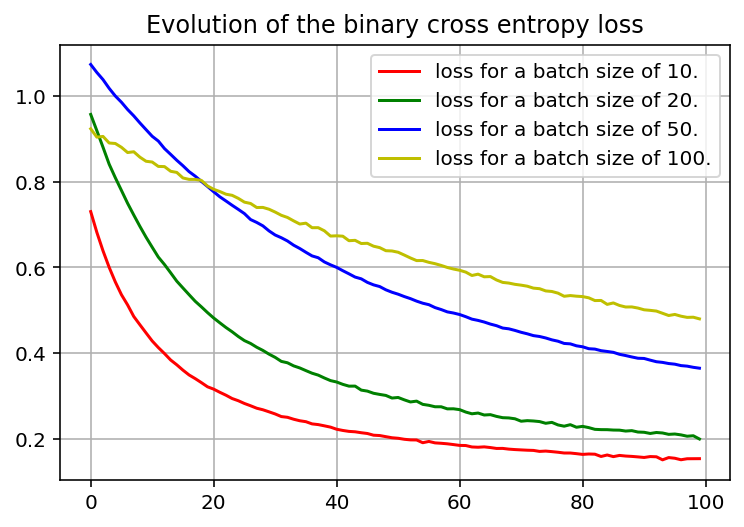

In [40]:
batch_sizes = [10, 20, 50, 100]
colors = ['r', 'g', 'b', 'y']


# Plot of the SGD of a logistic regressor with different batch sizes.

for i in zip(batch_sizes, colors):

  my_LR_stochastic = LR_stochastic(x.shape[1], num_train_data = x.shape[0], lr=0.001, batch_size=i[0])
  my_LR_stochastic.train(torch.tensor(x), torch.tensor(y))

  plt.plot(my_LR_stochastic.loss_during_training, f'-{i[1]}', label=f'loss for a batch size of {i[0]}.')
  
plt.grid()
plt.legend(loc = 'best')
plt.title('Evolution of the binary cross entropy loss')
plt.show()